## Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore

## Load and Explore data
### Data Overview
- 20+ million transactions
- Features: step, type, amount, origin/receive balances, week, day, hour 

In [7]:
df = pd.read_csv('data/transformed_data.csv')
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,week,day,hour
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,1,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,1,1,0
2,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,1,1,0
3,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,1,1,0
4,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2151490,718,PAYMENT,8178.01,C1213413071,11742.0,3563.99,M1112540487,0.0,0.0,5,30,21
2151491,718,PAYMENT,17841.23,C1045048098,10182.0,0.00,M1878955882,0.0,0.0,5,30,21
2151492,718,PAYMENT,1022.91,C1203084509,12.0,0.00,M675916850,0.0,0.0,5,30,21
2151493,718,PAYMENT,4109.57,C673558958,5521.0,1411.43,M1126011651,0.0,0.0,5,30,21


## Exploratory Data Analysis
1. Value distribution by transaction type
2. Time patterns (hourly/weekly)
3. Balance vs transaction relationships
4. Weekly Frequency

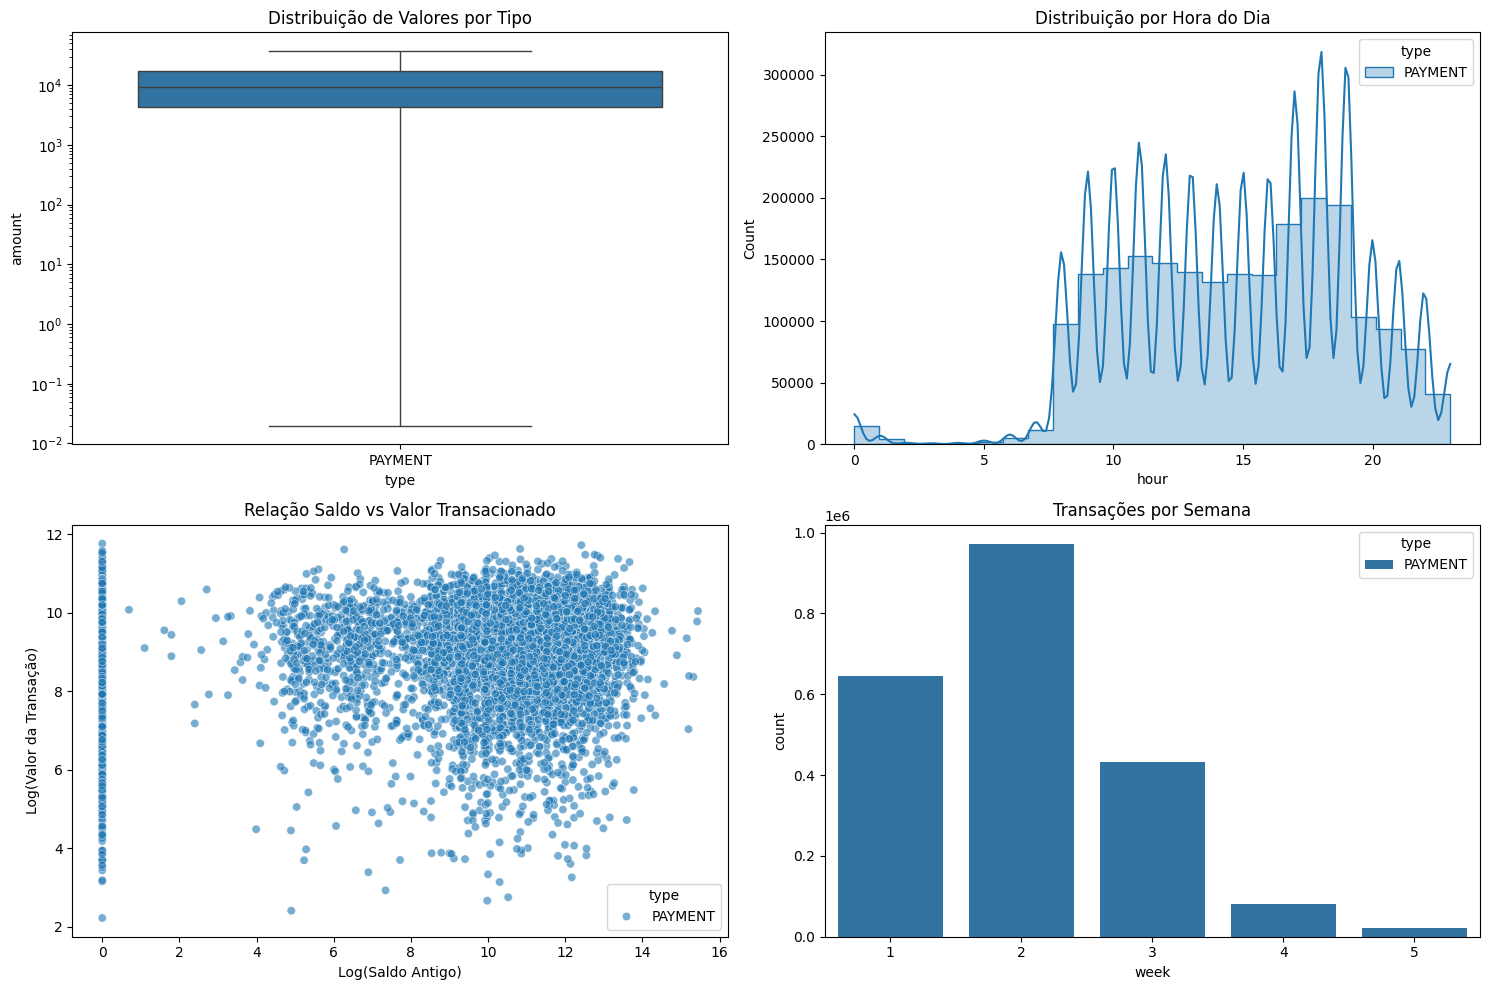

In [8]:
plt.figure(figsize=(15, 10))

# Distribution by transaction type
plt.subplot(2, 2, 1)
sns.boxplot(x='type', y='amount', data=df, showfliers=False)
plt.yscale('log')
plt.title('Distribuição de Valores por Tipo')

# Time Pattern
plt.subplot(2, 2, 2)
sns.histplot(data=df, x='hour', hue='type', bins=24, 
             element='step', kde=True, alpha=0.3)
plt.title('Distribuição por Hora do Dia')

# Balance vs Transaction Amount
plt.subplot(2, 2, 3)
sample = df.sample(10000)
sns.scatterplot(x=np.log1p(sample['oldbalanceOrg']), 
                y=np.log1p(sample['amount']), 
                hue='type', alpha=0.6, data=sample)
plt.title('Relação Saldo vs Valor Transacionado')
plt.xlabel('Log(Saldo Antigo)')
plt.ylabel('Log(Valor da Transação)')

# Weekly Frequency
plt.subplot(2, 2, 4)
sns.countplot(x='week', hue='type', data=df)
plt.title('Transações por Semana')

plt.tight_layout()
plt.show()


## Account Feature Engineering
1. Transaction frequency features
2. Balance evolution metrics
3. Time-based patterns
4. Transaction type ratios


In [ ]:
# Sort to ensure temporal order
df = df.sort_values(['nameOrig', 'step'])

# Account features - Basic aggregates
account_features_basic = df.groupby('nameOrig').agg(
    transaction_count=('amount', 'count'),
    avg_amount=('amount', 'mean'),
    median_amount=('amount', 'median'),
    amount_std=('amount', 'std'),
    payment_ratio=('type', lambda x: (x == 'PAYMENT').mean()),
    debit_ratio=('type', lambda x: (x == 'DEBIT').mean()),
    avg_hour=('hour', 'mean'),
    nighttime_ratio=('hour', lambda x: ((x >= 22) | (x <= 6)).mean()),
    weekly_frequency=('week', 'nunique')
).reset_index()

# Account features - Balance calculations
balance_features = df.groupby('nameOrig').agg(
    initial_balance=('oldbalanceOrg', 'first'),
    final_balance=('newbalanceOrig', 'last'),
    total_debited=('amount', lambda x: x[df.loc[x.index, 'type'] == 'DEBIT'].sum()),
    total_credited=('amount', lambda x: x[df.loc[x.index, 'type'] == 'PAYMENT'].sum())
).reset_index()

balance_features['net_balance_change'] = balance_features['final_balance'] - balance_features['initial_balance']
balance_features['imbalance_ratio'] = (
    (balance_features['total_debited'] - balance_features['total_credited']) / 
    (balance_features['initial_balance'] + 0.01)  # Avoid division by zero
)

# Merge all account features
account_features = account_features_basic.merge(
    balance_features, 
    on='nameOrig', 
    how='left'
)

# Fill missing values
account_features.fillna(0, inplace=True)

In [ ]:
account_features.head()

,nameOrig,transaction_count,avg_amount,median_amount,amount_std,payment_ratio,debit_ratio,avg_hour,nighttime_ratio,weekly_frequency,initial_balance,final_balance,total_debited,total_credited,net_balance_change,imbalance_ratio
0,C1000001337,1,3170.28,3170.28,0.0,1.0,0.0,0.0,1.0,1,58089.00,54918.72,0.0,3170.28,-3170.28,-0.054576
1,C1000001725,1,8424.74,8424.74,0.0,1.0,0.0,21.0,0.0,1,783.00,0.00,0.0,8424.74,-783.00,-10.759428
2,C1000006873,1,4615.66,4615.66,0.0,1.0,0.0,11.0,0.0,1,313.00,0.00,0.0,4615.66,-313.00,-14.746046
3,C1000008111,1,13925.55,13925.55,0.0,1.0,0.0,13.0,0.0,1,31295.00,17369.45,0.0,13925.55,-13925.55,-0.444977
4,C1000009135,1,3849.38,3849.38,0.0,1.0,0.0,18.0,0.0,1,103120.55,99271.17,0.0,3849.38,-3849.38,-0.037329


# Account Clustering
## Behavior-Based Account Segmentation

Method: K-Means with automated elbow detection (second derivative)

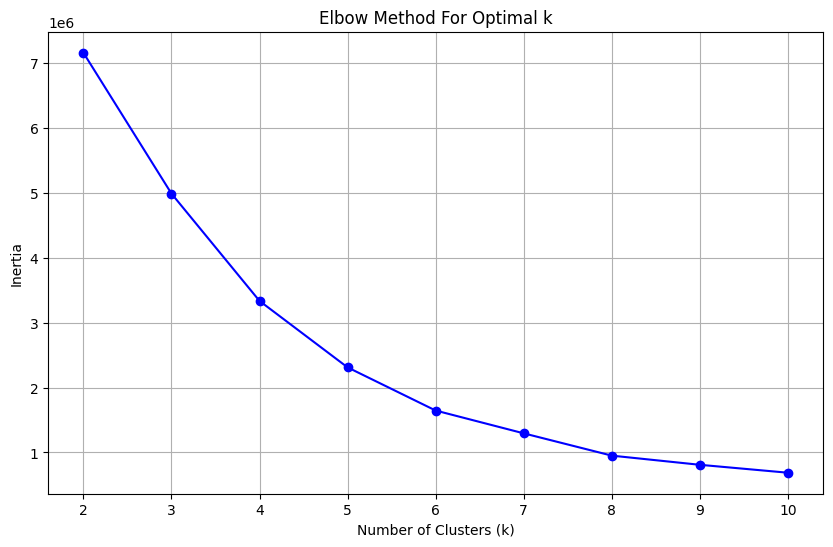

Automatically detected elbow at k = 8
Selected clusters: 8


In [ ]:
# Select and transform features
# Select and transform features
features = [
    'transaction_count', 'avg_amount', 'amount_std', 
    'payment_ratio', 'nighttime_ratio', 'weekly_frequency',
    'imbalance_ratio'
]

# Apply log transformation to reduce skewness
X = account_features[features].copy()
X['transaction_count'] = np.log1p(X['transaction_count'])
X['avg_amount'] = np.log1p(X['avg_amount'])
X['amount_std'] = np.log1p(X['amount_std'].replace(0, 0.01))

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculate inertia for different k values
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

# Automatic elbow detection
def find_elbow_point(inertias):
    """Automatically detect elbow point using second derivative"""
    diff = np.diff(inertias)          # First derivative
    diff_ratio = diff[1:] / diff[:-1]  # Second derivative
    elbow = np.argmin(diff_ratio) + 3  # Find point of max curvature
    return min(elbow, len(inertias) + 1)

optimal_k = find_elbow_point(inertias)
print(f"Automatically detected elbow at k = {optimal_k}")

# Apply KMeans with selected k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
account_features['cluster'] = kmeans.fit_predict(X_scaled)

print(f"Selected clusters: {optimal_k}")

In [ ]:
#Join only essential account features to transaction data
cluster_info = account_features[['nameOrig', 'cluster', 'imbalance_ratio', 
                                'avg_amount', 'amount_std']]

df = df.merge(cluster_info, on='nameOrig', how='left')

# Handle new accounts not seen during training
df['cluster'] = df['cluster'].fillna(-1)  # -1 = unclassified

# Create amount Z-score within clusters
def calculate_zscore(group):
    group['amount_zscore'] = (group['amount'] - group['avg_amount']) / (group['amount_std'] + 0.01)
    return group

df = df.groupby('cluster').apply(calculate_zscore)

# Save training statistics for production use
cluster_stats = account_features.groupby('cluster').agg(
    train_avg_amount=('avg_amount', 'mean'),
    train_amount_std=('amount_std', 'mean')
).reset_index()


C:\Users\joaop\AppData\Local\Temp\ipykernel_39436\119787875.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('cluster').apply(calculate_zscore)


In [ ]:
df['is_payment'] = (df['type'] == 'PAYMENT').astype(int)

## Detection Setup

### Cluster-Specific Anomaly Detection
1. Train separate Isolation Forest for each cluster
2. Custom contamination rates per cluster
3. Business-driven sensitivity tuning

Benefits:
- High-risk clusters can have higher sensitivity
- Low-activity clusters protected from false positives
- Adaptable to different account behaviors

In [ ]:
# Prepare features for anomaly detection
features = [
    'amount', 'oldbalanceOrg', 'newbalanceOrig', 
    'hour', 'day', 'is_payment', 'amount_zscore'
]

models = {}
contamination_rates = {}
df['anomaly_score'] = np.nan
df['is_anomaly'] = 0  # Initialize as normal (0)

for cluster_id in range(optimal_k):
    cluster_data = df[df['cluster'] == cluster_id]
    
    if len(cluster_data) == 0:
        print(f"Skipping empty cluster {cluster_id}")
        continue
        
    # Verificar se todas as colunas estão presentes
    missing_features = [f for f in features if f not in cluster_data.columns]
    if missing_features:
        # Tentar preencher features faltantes
        for feat in missing_features:
            if feat == 'is_payment':
                cluster_data['is_payment'] = (cluster_data['type'] == 'PAYMENT').astype(int)
            elif feat == 'amount_zscore':
                cluster_data['amount_zscore'] = (cluster_data['amount'] - cluster_data['avg_amount']) / (cluster_data['amount_std'] + 0.01)
        
        # Atualizar o DataFrame principal
        df.loc[cluster_data.index, missing_features] = cluster_data[missing_features]
    
    X_cluster = cluster_data[features].fillna(0)
 
    contamination = 0.01  # 1% fixo
    contamination_rates[cluster_id] = contamination
    print(f"Cluster {cluster_id}: using FIXED contamination = {contamination:.4f}")
    
    # Train Isolation Forest with fixed contamination
    clf = IsolationForest(
        n_estimators=100, 
        contamination=contamination,  # 1% fixo para todos os clusters
        random_state=42
    )
    clf.fit(X_cluster)
    
    # Save model
    models[cluster_id] = clf
    
    # Predict anomalies
    predictions = clf.predict(X_cluster)
    scores = clf.decision_function(X_cluster)
    
    # Store results
    # IsolationForest returns: 1 = normal, -1 = anomaly
    # We convert to: 0 = normal, 1 = anomaly
    df.loc[cluster_data.index, 'anomaly_score'] = scores
    df.loc[cluster_data.index, 'is_anomaly'] = (predictions == -1).astype(int)
 
 

NameError: name 'optimal_k' is not defined


Cluster Statistics:
   cluster  accounts  transactions  anomaly_rate  fraud_rate  \
0        0    644458        644458      0.010001      644458   
1        1       755          1511      0.010589        1511   
2        2    758128        758128      0.010001      758128   
3        3    143871        143871      0.010002      143871   
4        4    320312        320312      0.010003      320312   
5        5       338           676      0.010355         676   
6        6     78305         78305      0.009999       78305   
7        7    204234        204234      0.010003      204234   

   avg_anomaly_score  
0           0.213570  
1           0.206505  
2           0.233622  
3           0.249967  
4           0.140973  
5           0.186425  
6           0.181452  
7           0.224556  


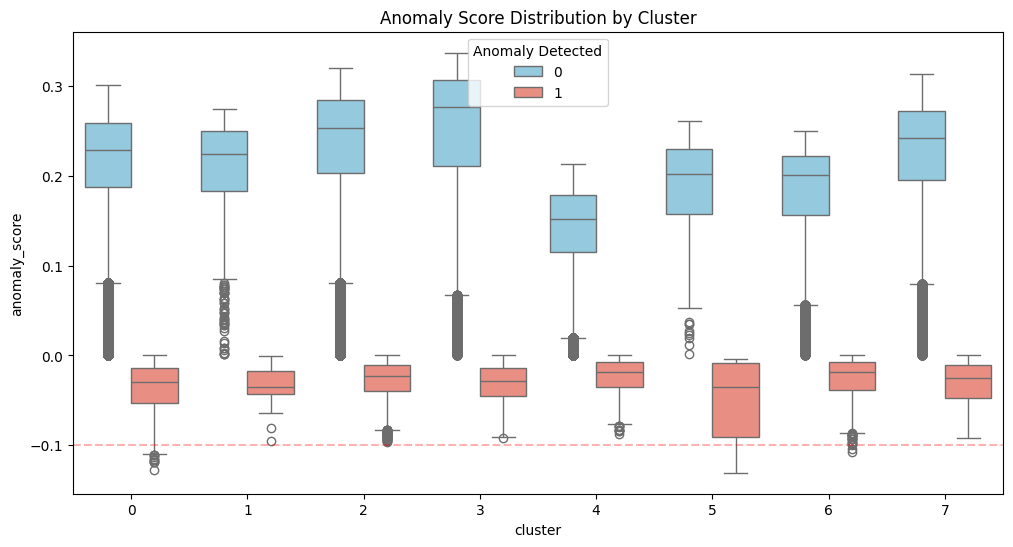

In [ ]:
if 'cluster' in df.index.names:
    df = df.reset_index(level='cluster', drop=True)

cluster_stats = df.groupby('cluster').agg(
    accounts=('nameOrig', 'nunique'),
    transactions=('amount', 'count'),
    anomaly_rate=('is_anomaly', 'mean'),
    fraud_rate=('isFraud', 'mean') if 'isFraud' in df.columns else ('amount', 'count'),
    avg_anomaly_score=('anomaly_score', 'mean')
).reset_index()

print("\nCluster Statistics:")
print(cluster_stats)

# Visualize anomaly scores
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='cluster', 
    y='anomaly_score', 
    hue='is_anomaly',
    data=df,
    palette={0: "skyblue", 1: "salmon"}
)
plt.title('Anomaly Score Distribution by Cluster')
plt.axhline(y=-0.1, color='r', linestyle='--', alpha=0.3)
plt.legend(title='Anomaly Detected')
plt.show()

# Fraud detection performance
if 'isFraud' in df.columns:
    fraud_cases = df[df['isFraud'] == 1]
    detection_rate = fraud_cases['is_anomaly'].mean()
    print(f"\nFraud Detection Rate: {detection_rate:.2%}")

## Anomaly Visualization (PCA)

### Visual Inspection of Anomalies
Technique: Principal Component Analysis (PCA)
- 2D/3D visualization of high-dimension transaction space
- Validate model decisions and tunning isolation Tree
- Explain anomalies to business stakeholders
"""

Criando visualizações PCA por cluster...

Visualizing Cluster 0 (644458 transactions)


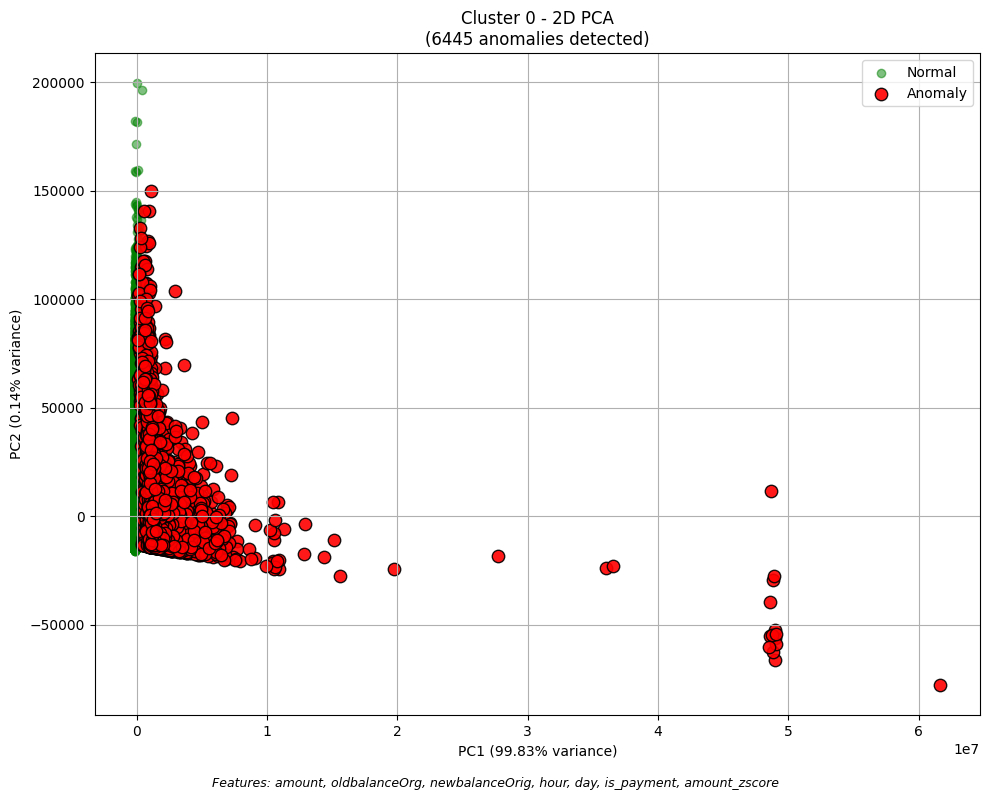

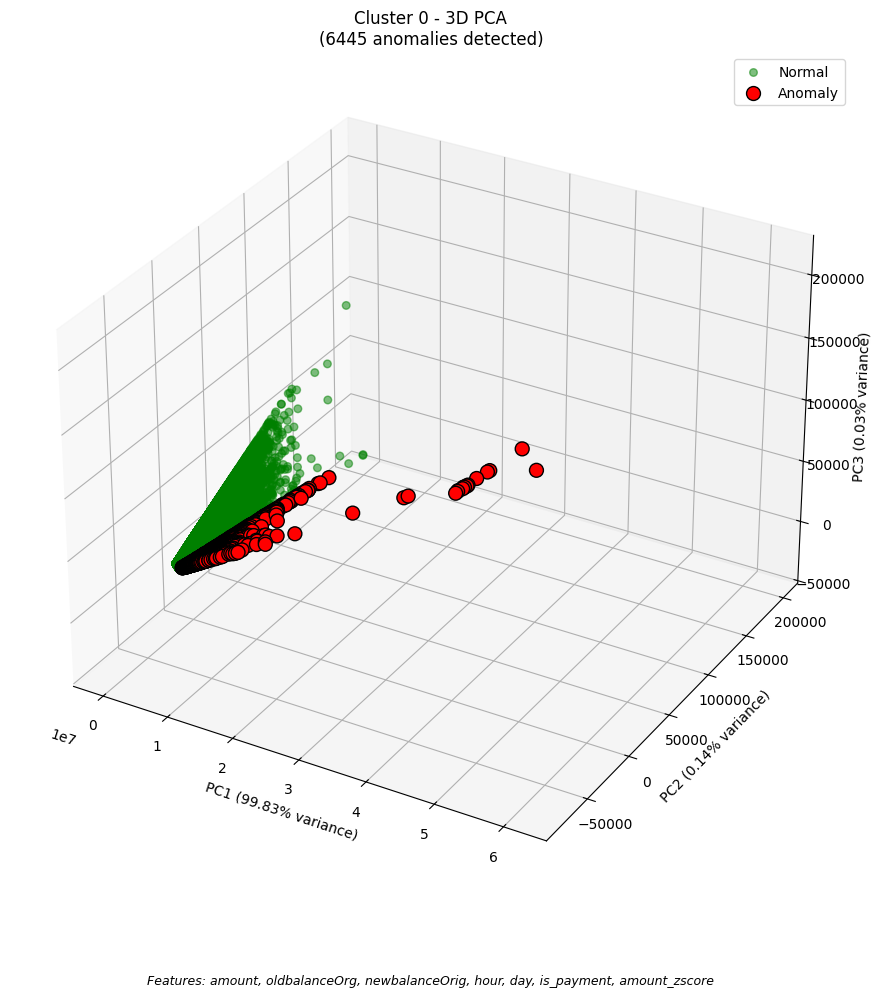


Visualizing Cluster 1 (1511 transactions)


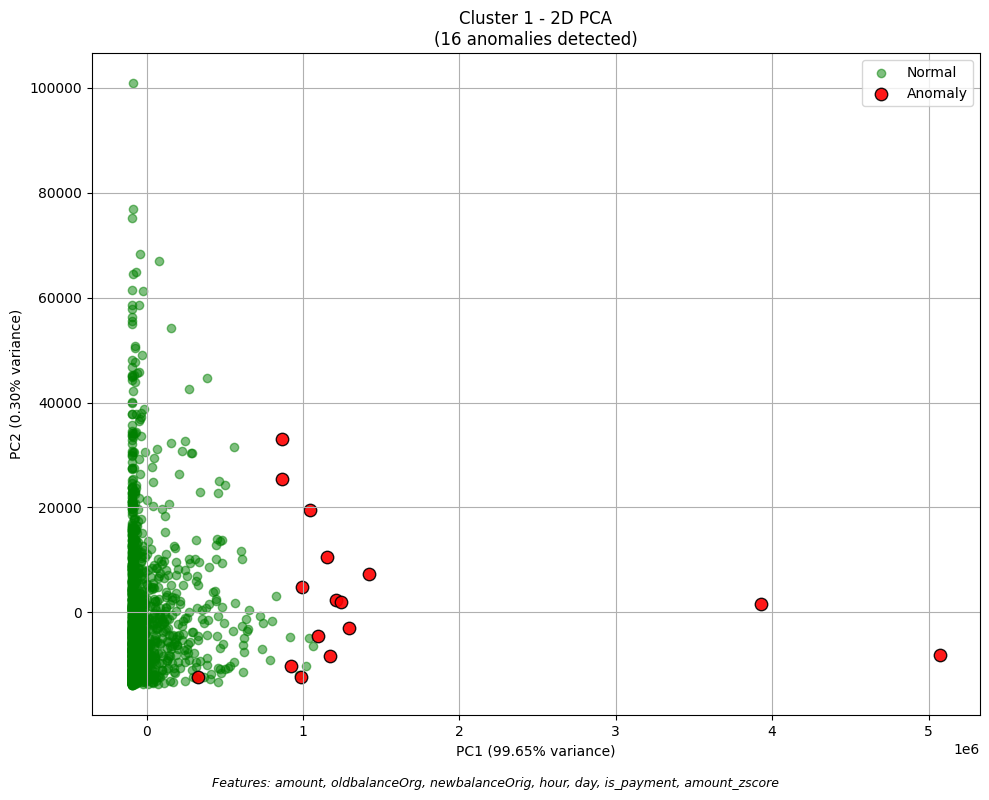

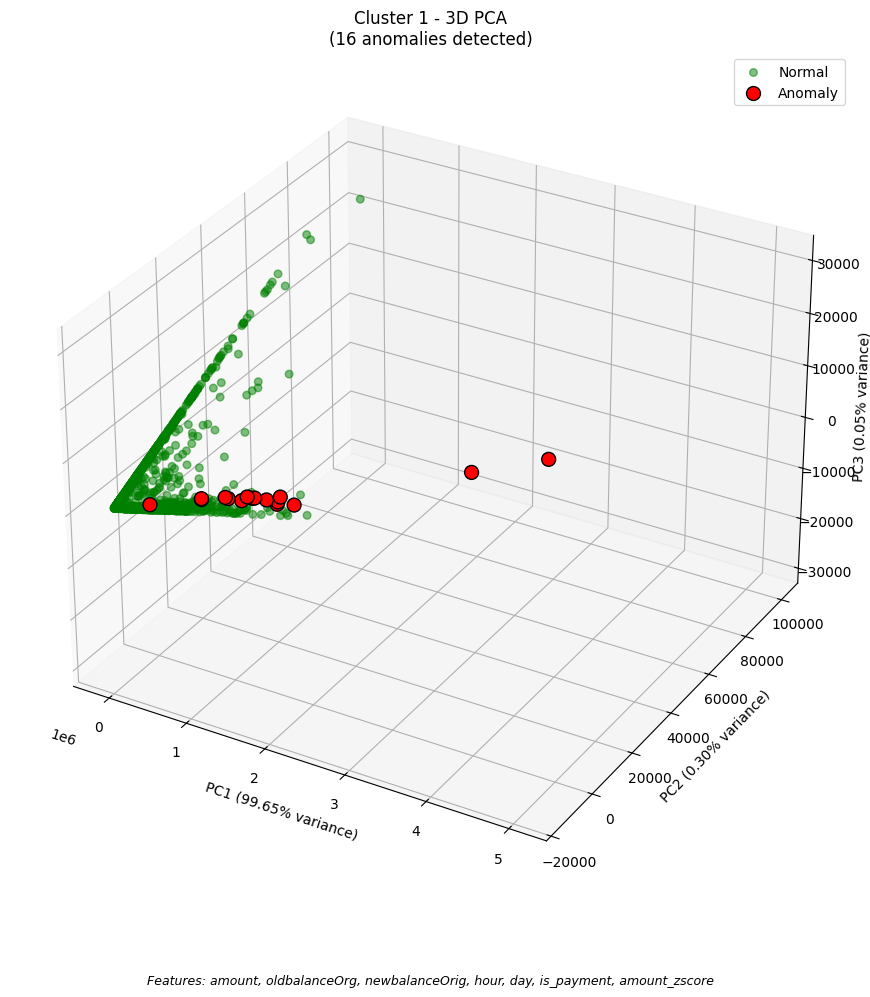


Visualizing Cluster 2 (758128 transactions)


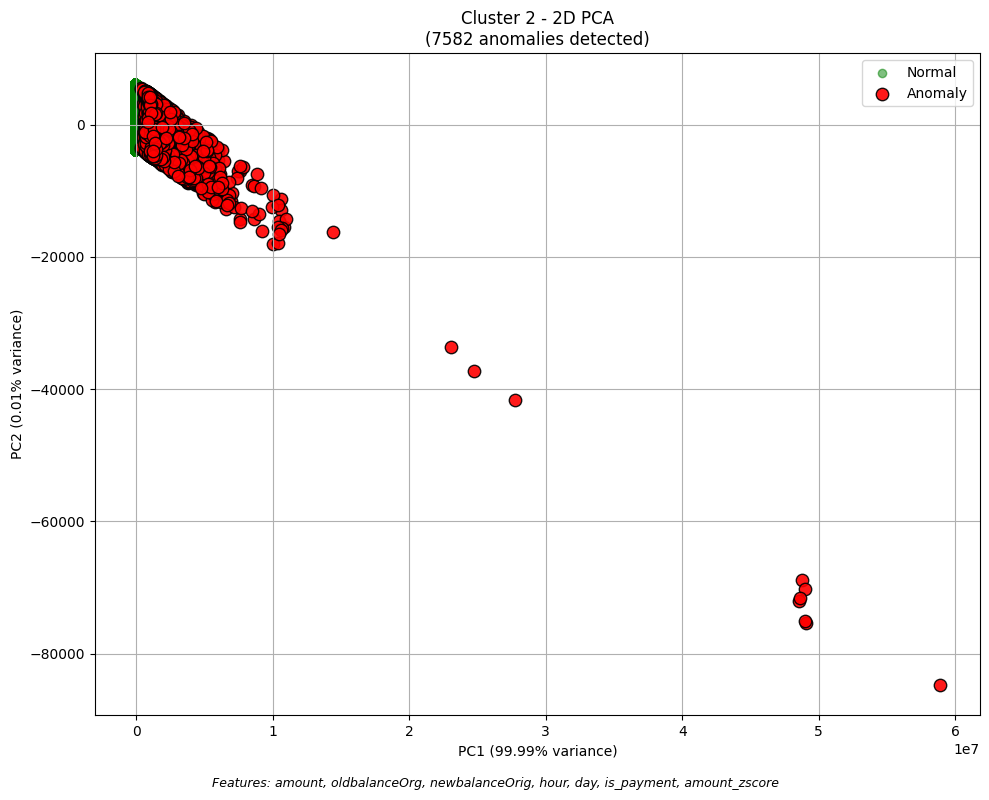

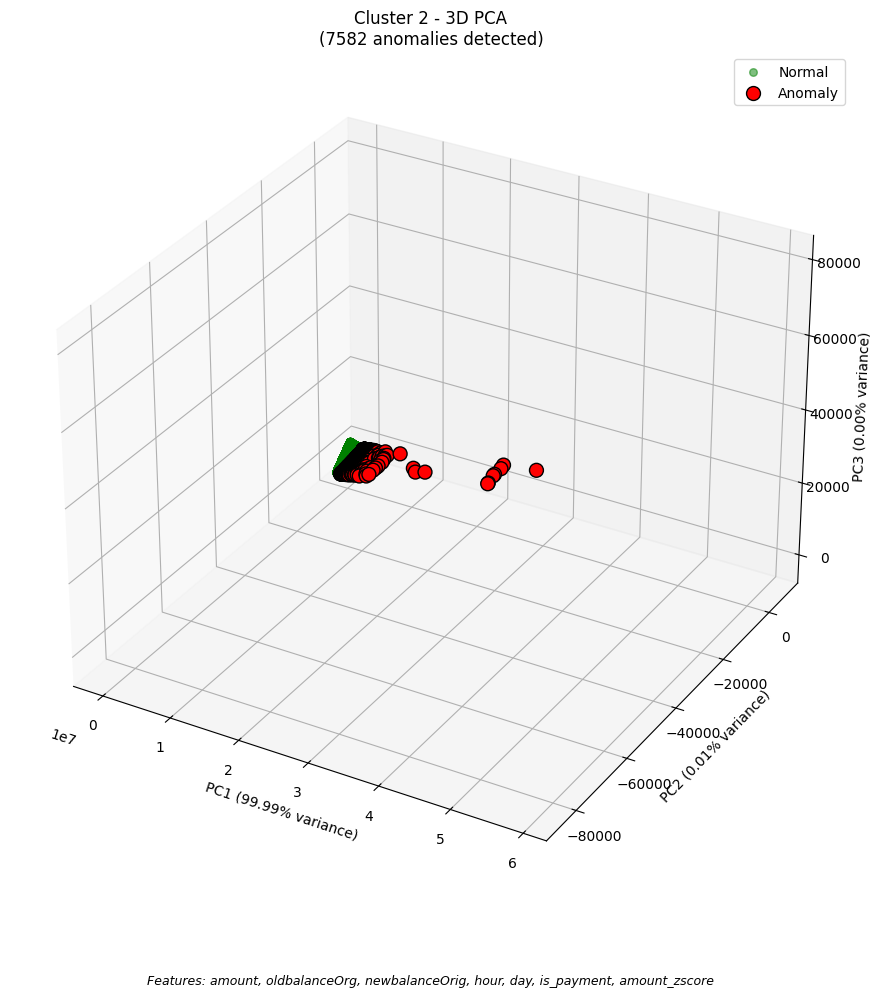


Visualizing Cluster 3 (143871 transactions)


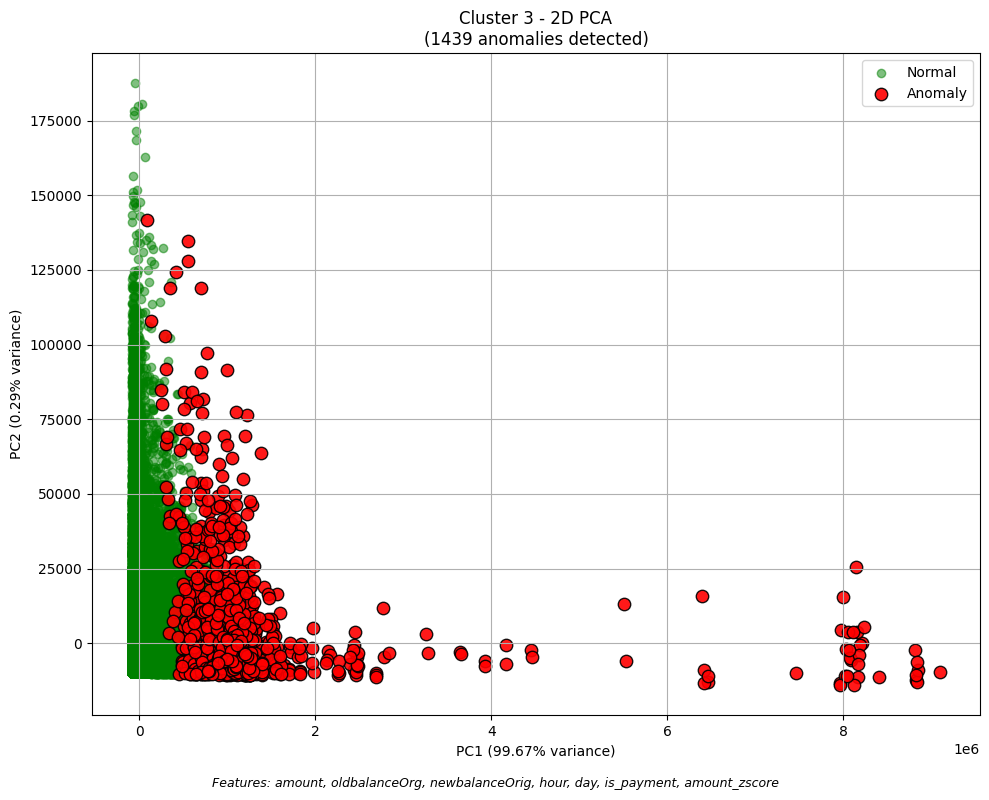

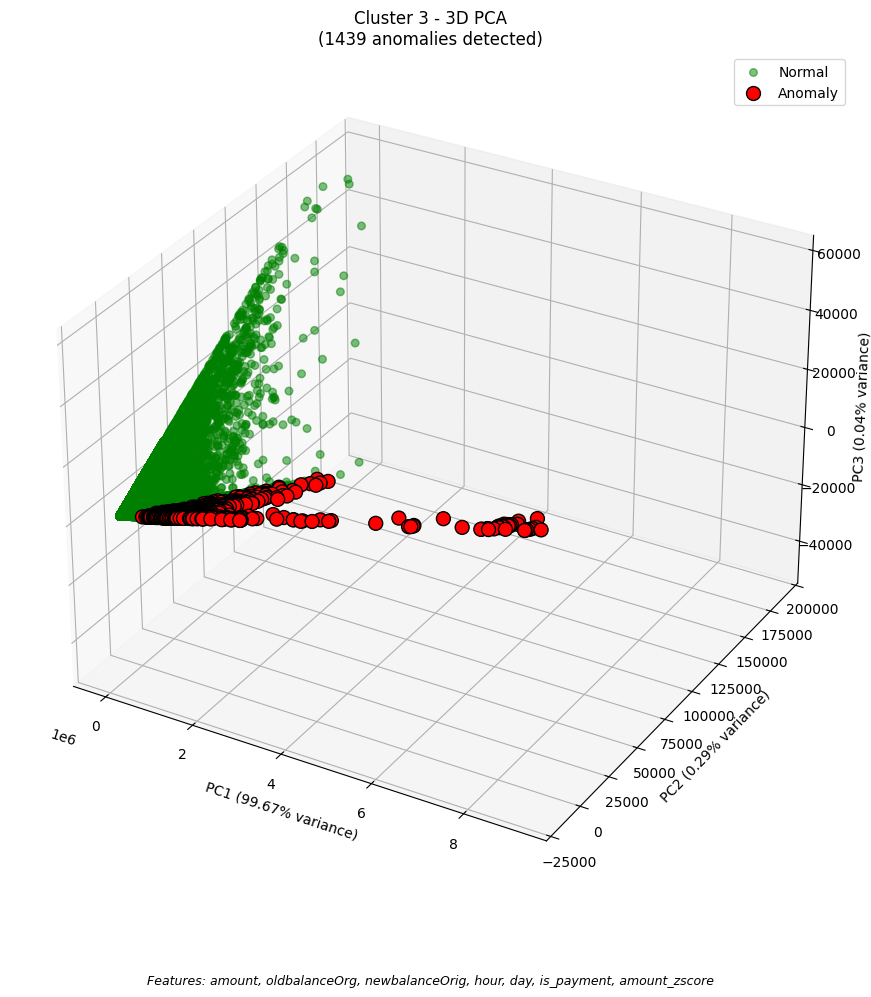


Visualizing Cluster 4 (320312 transactions)


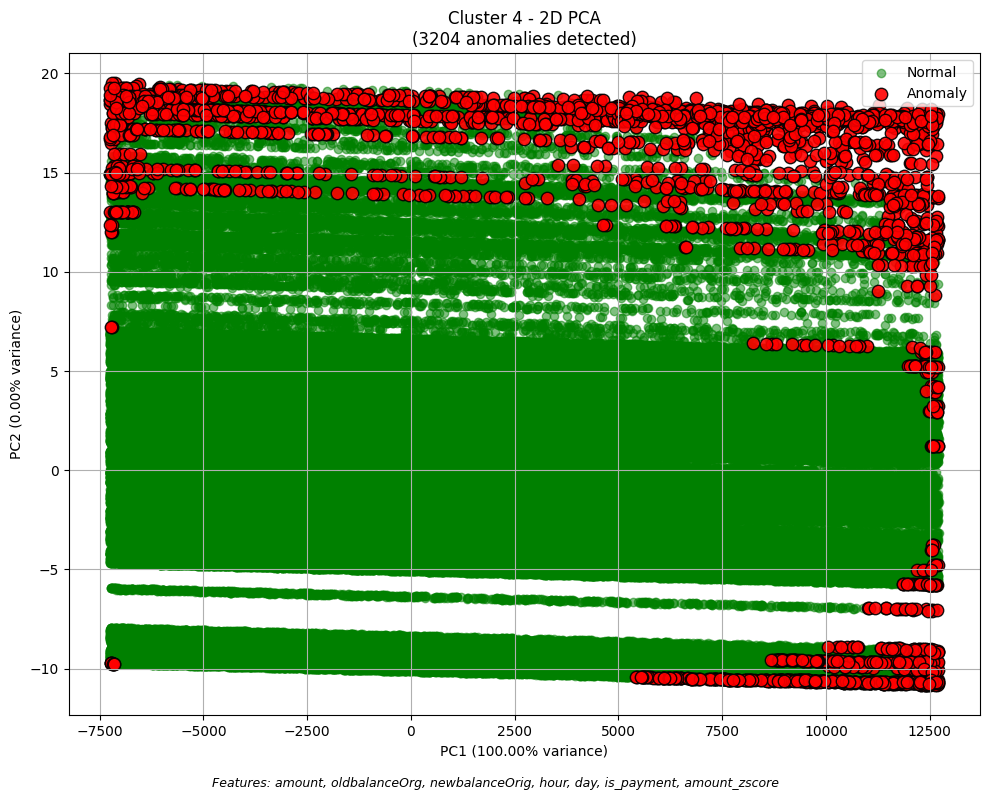

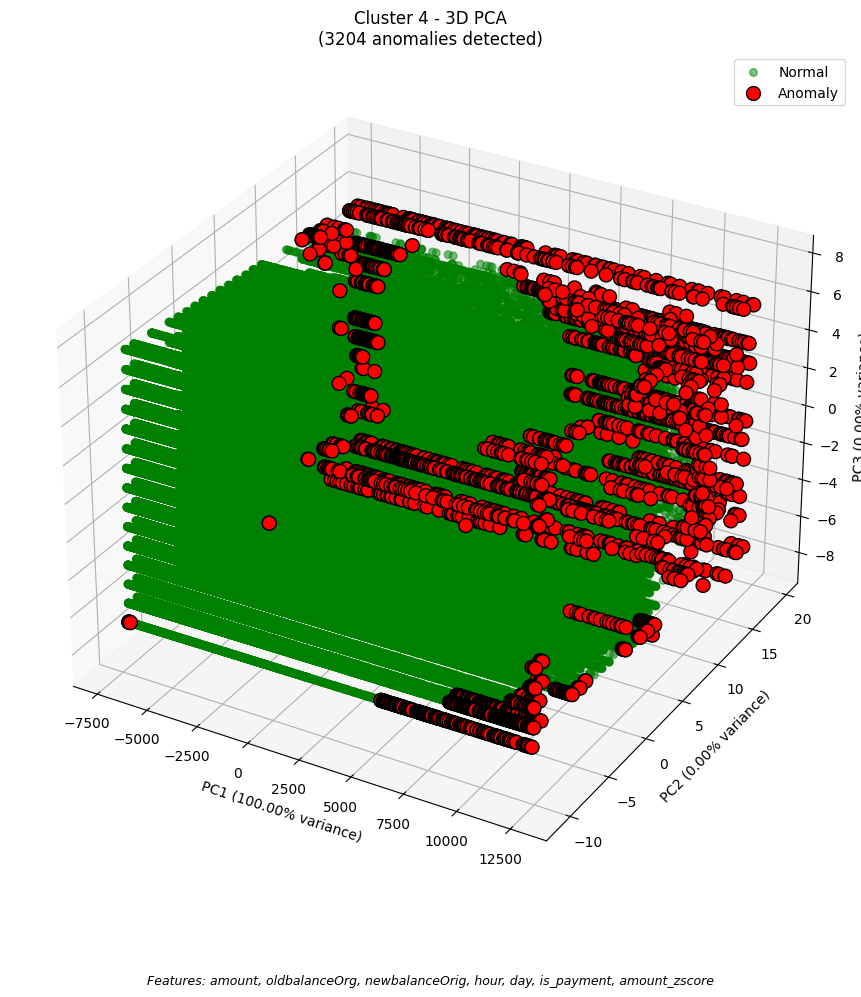


Visualizing Cluster 5 (676 transactions)


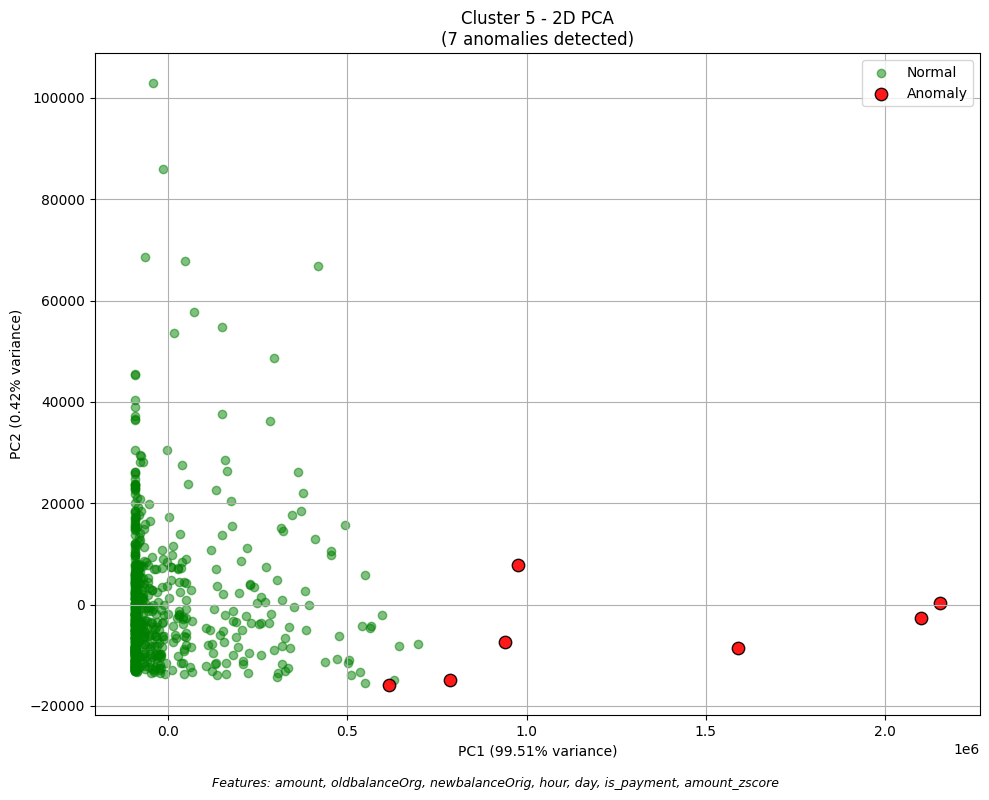

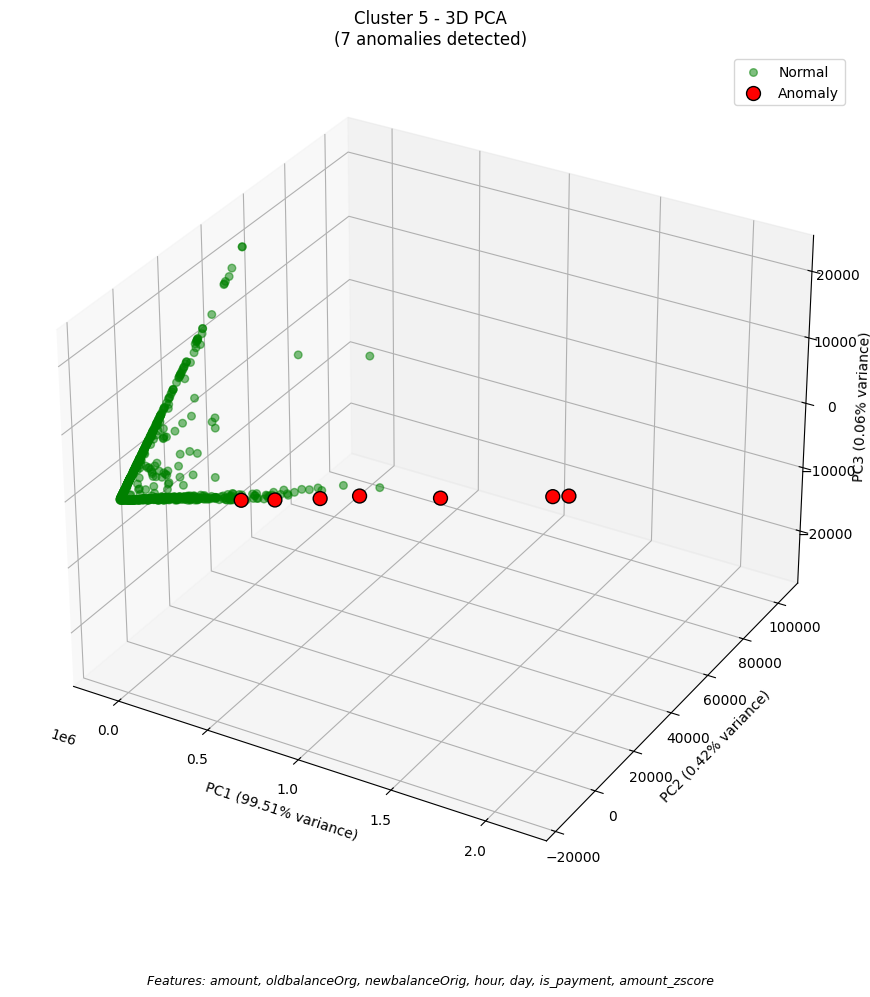


Visualizing Cluster 6 (78305 transactions)


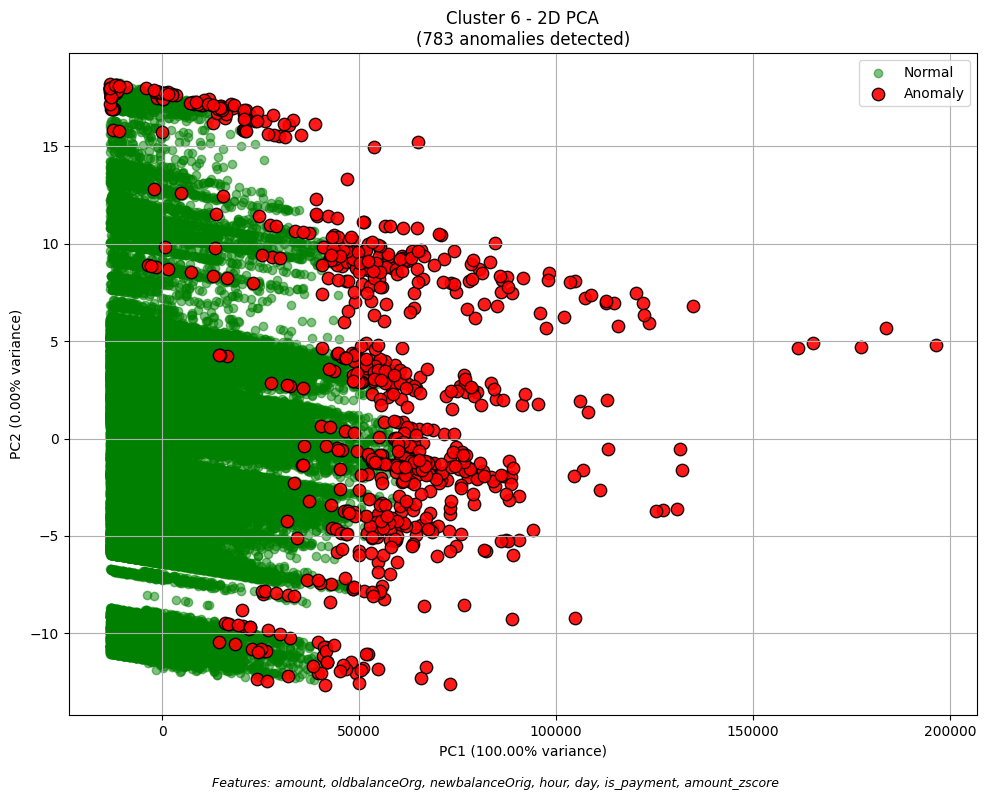

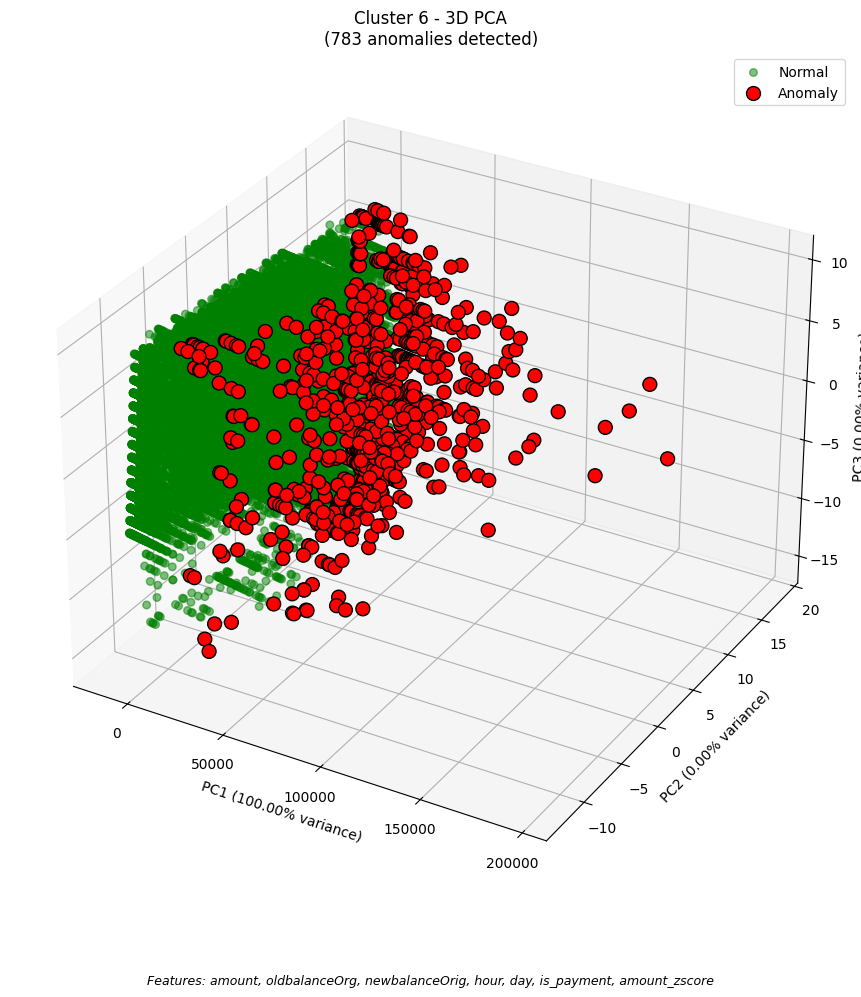


Visualizing Cluster 7 (204234 transactions)


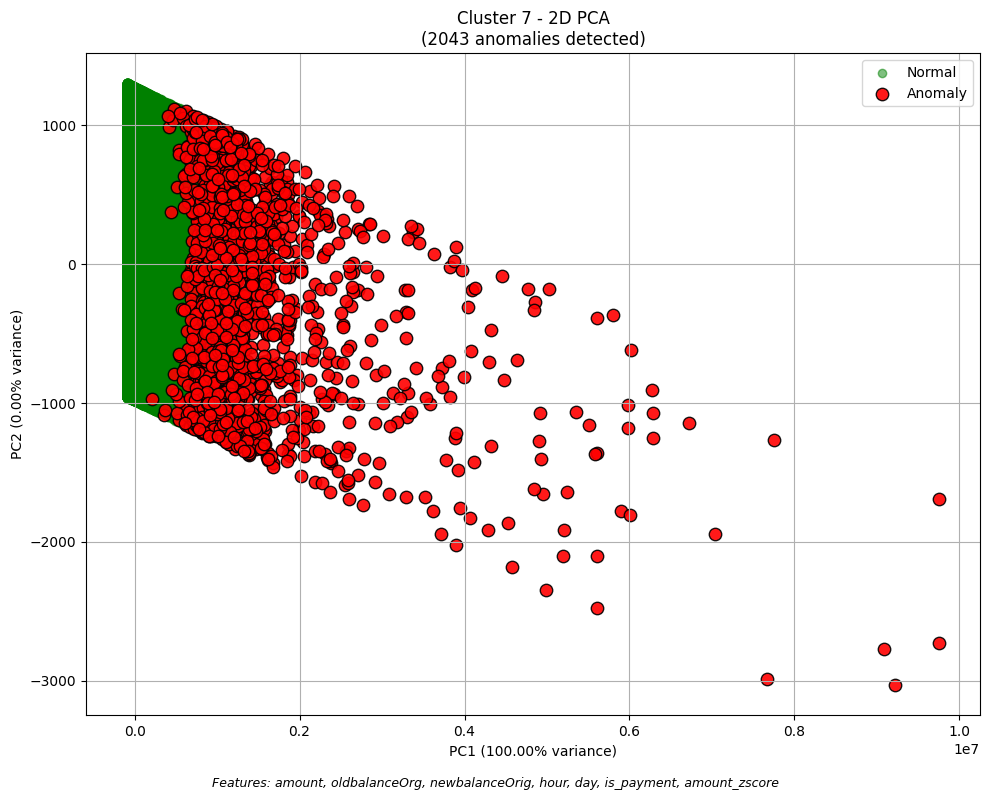

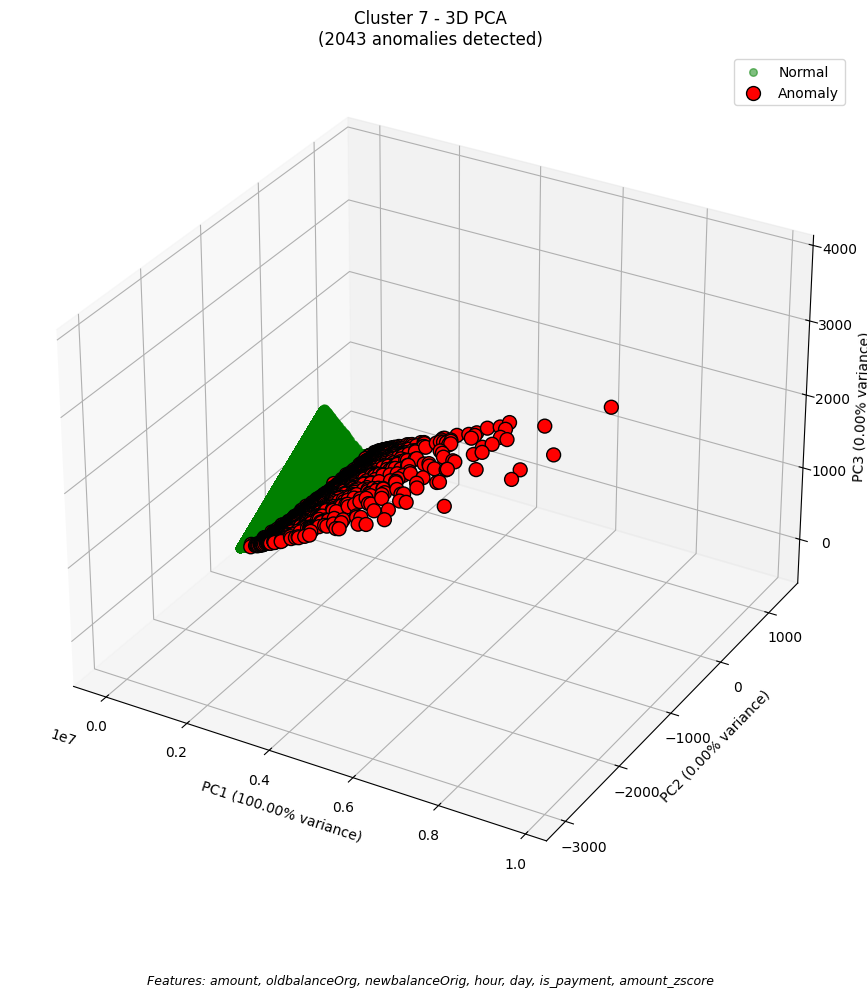

In [ ]:
# For each cluster
for cluster_id in sorted(df['cluster'].unique()):
    if cluster_id == -1:  # Skip unclassified
        continue
        
    cluster_data = df[df['cluster'] == cluster_id]
    
    # Skip small clusters
    if len(cluster_data) < 10:
        print(f"Skipping small cluster {cluster_id} (n={len(cluster_data)})")
        continue
        
    print(f"\nVisualizing Cluster {cluster_id} ({len(cluster_data)} transactions)")
    
    # Prepare features for PCA
    features = [
        'amount', 'oldbalanceOrg', 'newbalanceOrig', 
        'hour', 'day', 'is_payment', 'amount_zscore'
    ]
    X_cluster = cluster_data[features].fillna(0)
    
    # Apply PCA
    pca_2d = PCA(n_components=2)
    components_2d = pca_2d.fit_transform(X_cluster)
    
    pca_3d = PCA(n_components=3)
    components_3d = pca_3d.fit_transform(X_cluster)
    
    # Create DataFrames
    pca_df = pd.DataFrame({
        'PC1_2d': components_2d[:, 0],
        'PC2_2d': components_2d[:, 1],
        'PC1_3d': components_3d[:, 0],
        'PC2_3d': components_3d[:, 1],
        'PC3_3d': components_3d[:, 2],
        'is_anomaly': cluster_data['is_anomaly']
    })
    

    plt.figure(figsize=(10, 8))
    
    # Normal transactions
    normal = pca_df[pca_df['is_anomaly'] == 0]
    plt.scatter(normal['PC1_2d'], normal['PC2_2d'], 
                alpha=0.5, c='green', label='Normal')
    
    # Anomalies
    anomalies = pca_df[pca_df['is_anomaly'] == 1]
    plt.scatter(anomalies['PC1_2d'], anomalies['PC2_2d'], 
                alpha=0.9, c='red', edgecolor='black',
                s=80, label='Anomaly')
    
    plt.title(f'Cluster {cluster_id} - 2D PCA\n'
              f'({len(anomalies)} anomalies detected)')
    plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()
    plt.grid(True)
    
    # Add explanation of features
    plt.figtext(0.5, 0.01, 
                f"Features: {', '.join(features)}", 
                ha="center", fontsize=9, style='italic')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()
    
    # ==============================
    # 10.2 3D Visualization
    # ==============================
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Normal transactions
    ax.scatter(normal['PC1_3d'], normal['PC2_3d'], normal['PC3_3d'],
               alpha=0.5, c='green', s=30, label='Normal')
    
    # Anomalies
    ax.scatter(anomalies['PC1_3d'], anomalies['PC2_3d'], anomalies['PC3_3d'],
               alpha=1.0, c='red', edgecolor='black', 
               s=100, label='Anomaly')
    
    ax.set_title(f'Cluster {cluster_id} - 3D PCA\n'
                 f'({len(anomalies)} anomalies detected)')
    ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%} variance)')
    ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%} variance)')
    ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%} variance)')
    
    # Create custom legend
    ax.legend()
    
    # Add explanation of features
    plt.figtext(0.5, 0.01, 
                f"Features: {', '.join(features)}", 
                ha="center", fontsize=9, style='italic')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()